In [2]:
# Install pyarrow if not already installed
try:
    import pyarrow
except ImportError:
    import sys
    !{sys.executable} -m pip install pyarrow

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [4]:
# Load the dataset with error handling
try:
    df = pd.read_csv('customer_orders copy.csv')
except FileNotFoundError:
    print("The specified file was not found.")
    exit()
except pd.errors.EmptyDataError:
    print("The file is empty.")
    exit()
except pd.errors.ParserError:
    print("The file contains parsing errors.")
    exit()

In [5]:
# Make a copy of the dataset
df_copy = df.copy()
print("Type of df_copy:", type(df_copy))
print("Column names before standardization:", df_copy.columns)

# Standardize column names by replacing spaces with underscores and converting to lowercase
df_copy.columns = df_copy.columns.str.replace(' ', '_', regex=False).str.lower()
print("Column names after standardization:", df_copy.columns)

# Drop irrelevant columns
if 'email' in df_copy.columns:
    df_copy = df_copy.drop('email', axis=1)

# Anonymize customer names if the column exists
if 'customer_name' in df_copy.columns:
    df_copy['customer_name'] = df_copy['customer_name'].apply(lambda x: 'Customer_' + str(hash(x) % 10**8))

# List of numeric columns containing monetary values
numeric_columns = ['total_spent', 'total_orders', 'average_purchase', 'average_monthly_spend', 'average_monthly_orders']

# Convert numeric columns to floats after removing special characters
for col in numeric_columns:
    df_copy[col] = df_copy[col].replace(r'[\$,]', '', regex=True).astype(float)

# Convert date columns to datetime format
for date_col in ['customer_since', 'last_ordered']:
    if date_col in df_copy.columns:
        df_copy[date_col] = pd.to_datetime(df_copy[date_col], errors='coerce')

# Feature Engineering
df_copy['customer_tenure'] = (df_copy['last_ordered'] - df_copy['customer_since']).dt.days
df_copy['recency'] = (pd.to_datetime('today') - df_copy['last_ordered']).dt.days

# Handle missing values
df_copy.fillna(0, inplace=True)

# Calculate Customer Lifetime Value (CLV)
historical_clv = df_copy.groupby('customer_name')['total_spent'].sum()
print(historical_clv)

Type of df_copy: <class 'pandas.core.frame.DataFrame'>
Column names before standardization: Index(['Customer Name', 'Email', 'Total Spent', 'Total Orders',
       'Average Purchase', 'Average Monthly Spend', 'Average Monthly Orders',
       'Last Ordered', 'Customer Since', 'Customer Lifetime'],
      dtype='object')
Column names after standardization: Index(['customer_name', 'email', 'total_spent', 'total_orders',
       'average_purchase', 'average_monthly_spend', 'average_monthly_orders',
       'last_ordered', 'customer_since', 'customer_lifetime'],
      dtype='object')
customer_name
Customer_10008213     33.38
Customer_10019503     12.55
Customer_10075592     45.72
Customer_1009015      24.68
Customer_10120033     11.74
                      ...  
Customer_99871993     86.66
Customer_9993495      22.96
Customer_99962273      6.56
Customer_9996262     121.69
Customer_9998517     127.94
Name: total_spent, Length: 4765, dtype: float64


       total_spent  total_orders  average_purchase  average_monthly_spend  \
count  5025.000000   5025.000000       5025.000000            5025.000000   
mean     91.954762      3.324577         34.852736               4.664764   
min       4.450000      1.000000          4.450000               0.050000   
25%      19.800000      1.000000         14.470000               0.590000   
50%      35.510000      1.000000         22.950000               1.490000   
75%      88.060000      2.000000         38.450000               4.140000   
max    2995.820000    220.000000        911.020000             529.280000   
std     192.981239      8.339908         41.090587              13.412739   

       average_monthly_orders                   last_ordered  \
count             5025.000000                           5025   
mean                 0.034030  2021-07-18 13:33:51.044776192   
min                  0.000000            2014-12-16 00:00:00   
25%                  0.000000            2020-06-2

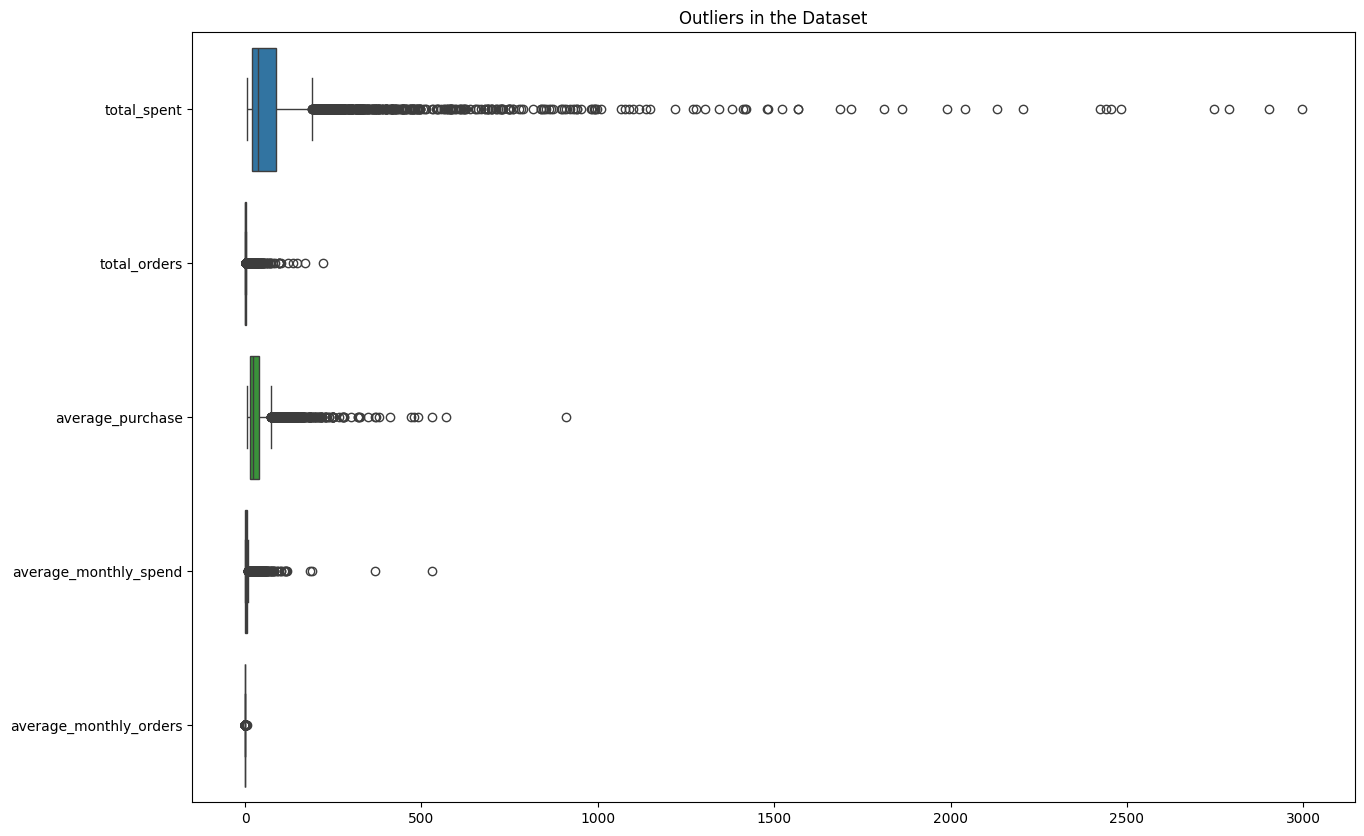

In [6]:
# Summary Statistics and Outliers
print(df_copy.describe())
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_copy[numeric_columns], orient='h')
plt.title('Outliers in the Dataset')
plt.show()

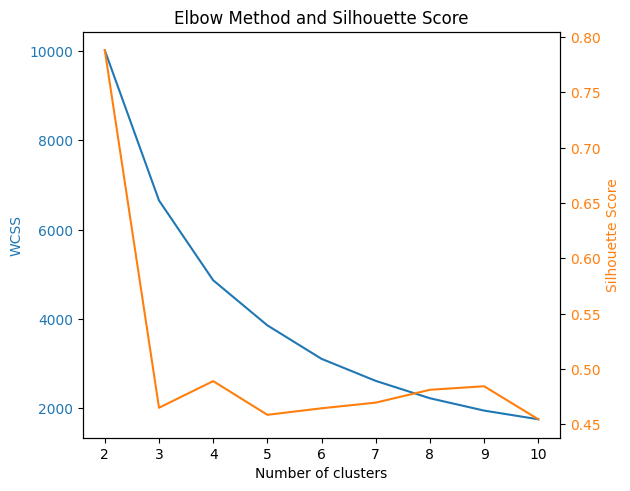

In [7]:
# Clustering
df_cluster = df_copy[['total_spent', 'total_orders', 'recency']]
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Determine the optimal number of clusters using the Elbow Method and Silhouette Score
wcss = []
silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_cluster_scaled)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(df_cluster_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Create a figure with two y-axes
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(range(2, 11), wcss, label='WCSS', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range(2, 11), silhouette_scores, label='Silhouette Score', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Elbow Method and Silhouette Score')
plt.show()

# Fit KMeans with the optimal number of clusters
optimal_clusters = 4  # Based on the elbow and silhouette score analysis
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_copy['cluster_label'] = kmeans.fit_predict(df_cluster_scaled)

In [8]:
# Ensure that only numeric columns are used for the summary
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_clusters = df_copy.groupby('cluster_label')[numeric_cols].mean()
print(df_clusters)

# Descriptive statistics for each cluster
cluster_summary = df_copy.groupby('cluster_label').describe().transpose()
print(cluster_summary)

               total_spent  total_orders  average_purchase  \
cluster_label                                                
0                65.314151      2.282772         34.078911   
1                45.828197      1.544279         33.564764   
2              1725.346400     84.480000         38.451200   
3               557.334378     19.642570         52.450602   

               average_monthly_spend  average_monthly_orders  customer_tenure  \
cluster_label                                                                   
0                           5.079825                0.030899       974.156367   
1                           0.747072                0.000000       362.262443   
2                          38.086000                1.160000      1978.440000   
3                          20.308474                0.172691      1547.971888   

                   recency  cluster_label  
cluster_label                              
0               697.334270            0.0  
1       

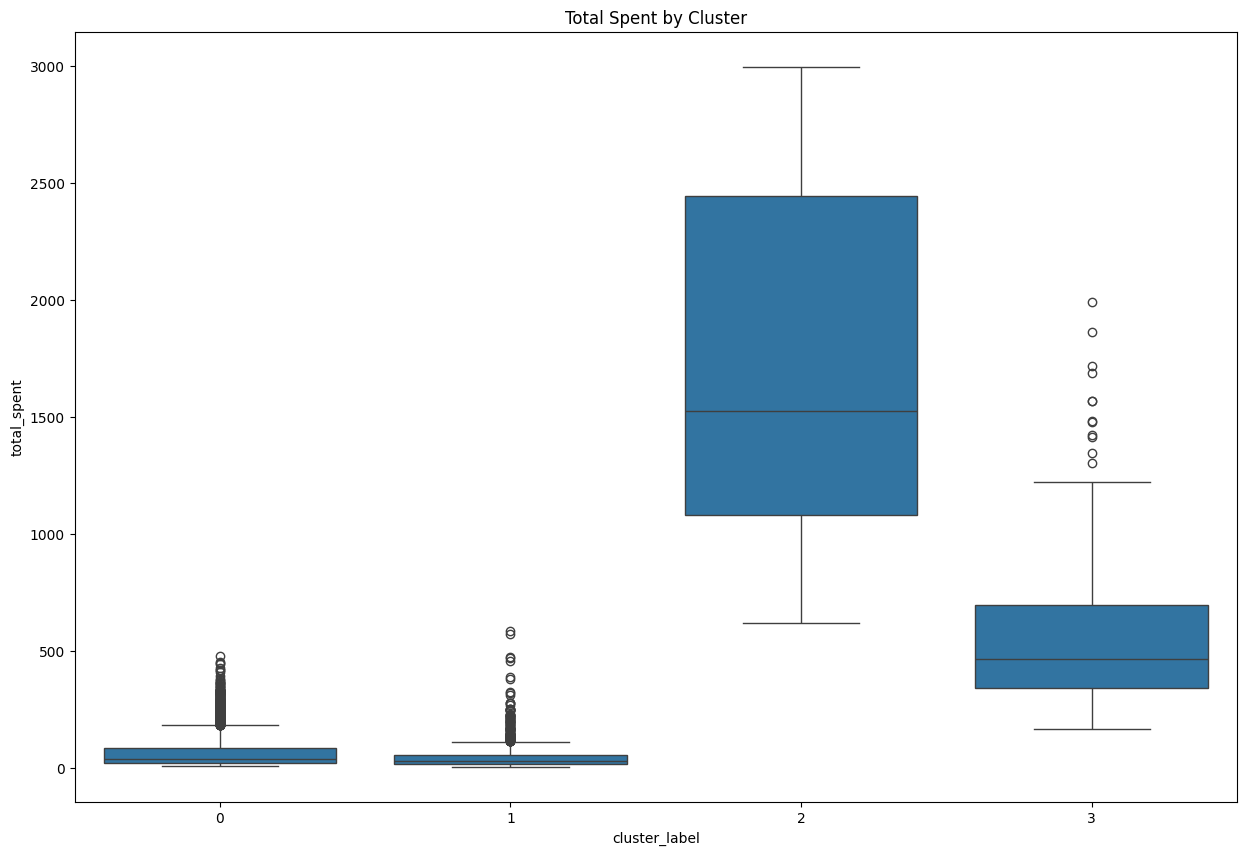

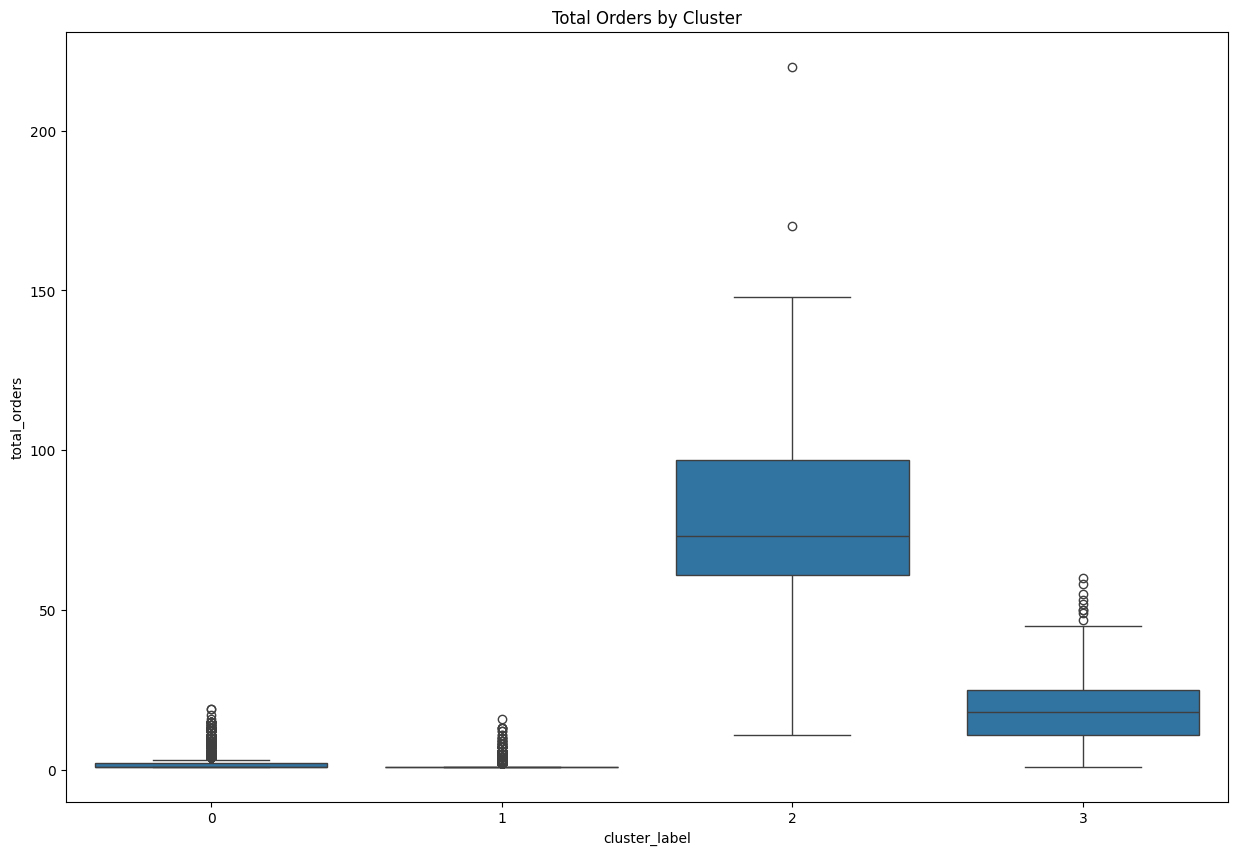

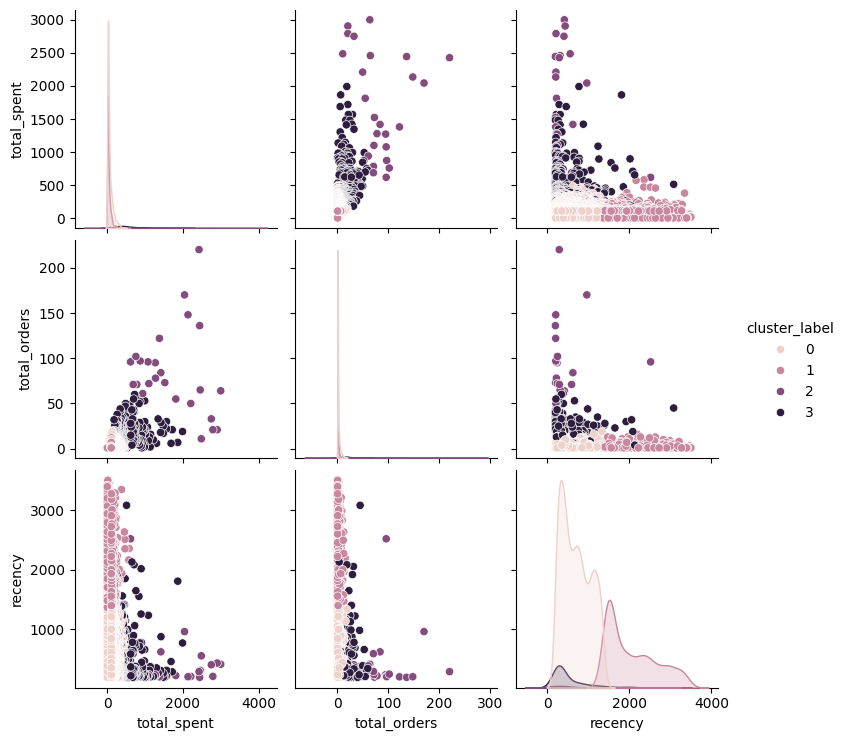

In [9]:
# Box plots for numeric variables in each cluster
plt.figure(figsize=(15, 10))
sns.boxplot(x='cluster_label', y='total_spent', data=df_copy)
plt.title('Total Spent by Cluster')
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(x='cluster_label', y='total_orders', data=df_copy)
plt.title('Total Orders by Cluster')
plt.show()

# Pair plots to visualize relationships between variables in different clusters
sns.pairplot(df_copy, hue='cluster_label', vars=['total_spent', 'total_orders', 'recency'])
plt.show()

In [10]:
# Cluster profiles
cluster_profiles = df_copy.groupby('cluster_label').agg({
    'total_spent': ['mean', 'median', 'std'],
    'total_orders': ['mean', 'median', 'std'],
    'recency': ['mean', 'median', 'std'],
    'customer_tenure': ['mean', 'median', 'std']
}).reset_index()
print(cluster_profiles)

  cluster_label  total_spent                      total_orders         \
                        mean   median         std         mean median   
0             0    65.314151    37.27   69.950717     2.282772    1.0   
1             1    45.828197    28.23   53.887748     1.544279    1.0   
2             2  1725.346400  1522.04  783.324398    84.480000   73.0   
3             3   557.334378   466.16  323.922706    19.642570   18.0   

                  recency                     customer_tenure          \
         std         mean  median         std            mean  median   
0   2.416757   697.334270   658.0  344.407005      974.156367   799.5   
1   1.505427  2059.210084  1876.0  603.115580      362.262443    15.0   
2  47.795676   426.360000   251.0  472.853296     1978.440000  1995.0   
3  11.546398   519.353414   343.0  438.512004     1547.971888  1352.0   

               
          std  
0  925.667850  
1  580.449579  
2  884.207182  
3  909.924489  


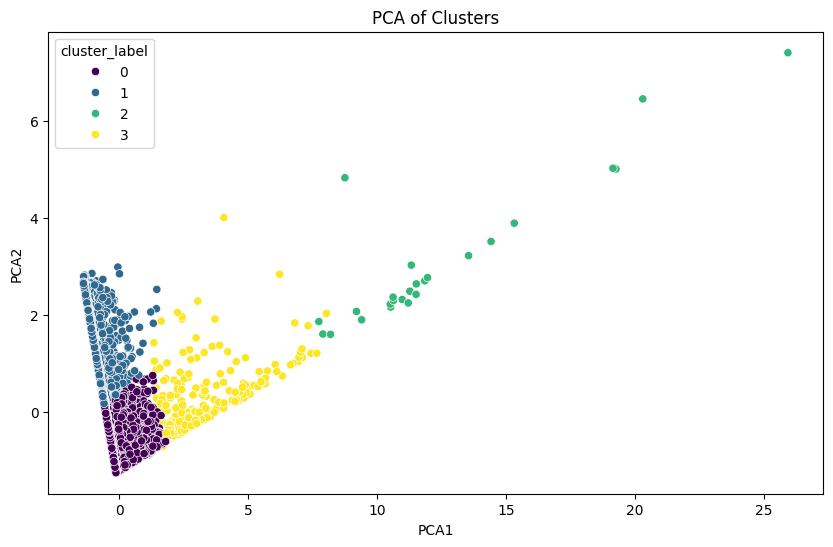

In [11]:
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_cluster_scaled)
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster_label'] = df_copy['cluster_label']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_label', data=pca_df, palette='viridis')
plt.title('PCA of Clusters')
plt.show()

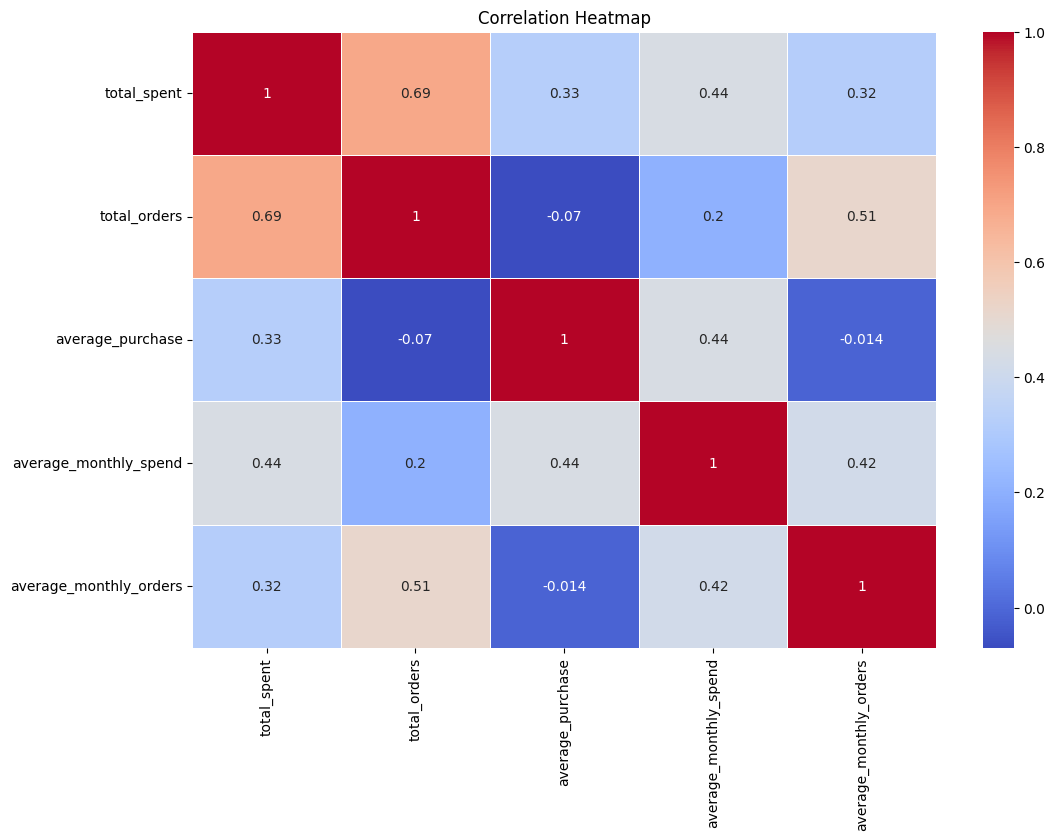

In [12]:
# Correlation matrix
correlation_matrix = df_copy[numeric_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
# Explore each cluster
for cluster in df_copy['cluster_label'].unique():
    cluster_data = df_copy[df_copy['cluster_label'] == cluster]
    print(f"Cluster {cluster} Summary:")
    print(cluster_data.describe())
    print("\n")

Cluster 2 Summary:
       total_spent  total_orders  average_purchase  average_monthly_spend  \
count    25.000000     25.000000         25.000000               25.00000   
mean   1725.346400     84.480000         38.451200               38.08600   
min     618.270000     11.000000          6.440000                6.18000   
25%    1078.150000     61.000000         11.230000               22.44000   
50%    1522.040000     73.000000         15.410000               29.01000   
75%    2440.770000     97.000000         37.770000               49.81000   
max    2995.820000    220.000000        225.730000              119.45000   
std     783.324398     47.795676         52.985571               27.78913   

       average_monthly_orders         last_ordered       customer_since  \
count               25.000000                   25                   25   
mean                 1.160000  2023-05-29 15:21:36  2017-12-28 04:48:00   
min                  0.000000  2017-09-05 00:00:00  2014-02-12

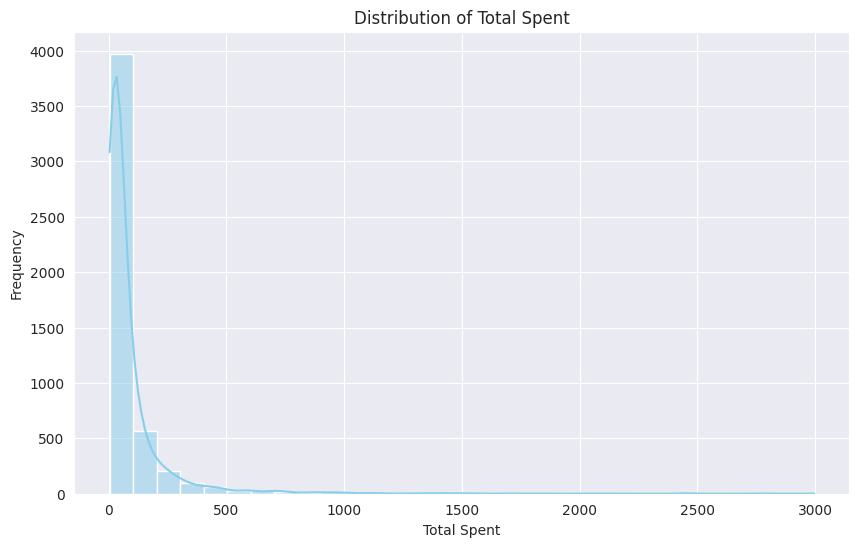

In [14]:
# Visualizations and Reporting
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_copy['total_spent'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Exporting segments to Excel
with pd.ExcelWriter('customer_segments.xlsx') as writer:
    for label in df_copy['cluster_label'].unique():
        df_copy[df_copy['cluster_label'] == label].to_excel(writer, sheet_name=f'Cluster_{label}')